## Suppl. Fig. 6 panels F, G Sankey plot and confusion matrix

In [46]:
import os, sys, itertools
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from pysankey import sankey

plt.rcParams['pdf.fonttype'] = 42

script_path = Path.cwd().parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent.parent  / "data"
sys.path.append(str(script_path))


output_folder = Path.cwd() / "output"
os.makedirs(output_folder, exist_ok=True)

### load data and prepare data

In [47]:
# load the data
annotations_df = pd.read_excel(data_path / "external" / 'Table_SX_annotation_including_imaging.xlsx', sheet_name='annotations_with_imaging')
print(annotations_df.shape)

(1310, 9)


In [48]:
# subset the data, avoid unclassified, mixed and N/A
data = annotations_df[(annotations_df["graph_annotation"].notna()) & (annotations_df["graph_annotation"] != "unclassified") & (annotations_df["annotations_grade3_simpler"] != "mixed")]
data.shape[0]

931

In [49]:
# check cytoself annotations
data["annotations_grade3_simpler"].unique()

array(['plasma_membrane', 'centrosome', 'nucleus', 'cytoplasm',
       'cytoskeleton', 'ER', 'Golgi', 'mitochondria', 'nuclear_membrane',
       'nucleolus', 'vesicles'], dtype=object)

In [50]:
# check OrgIP annotations
data["graph_annotation"].unique()

array(['plasma_membrane', 'actin_cytoskeleton', 'cytosol',
       'recycling_endosome', 'centrosome', 'nucleus', '14-3-3_scaffold',
       'nucleolus', 'translation', 'stress_granule', 'lysosome', 'ER',
       'early_endosome', 'proteasome', 'trans-Golgi', 'ERGIC', 'Golgi',
       'mitochondrion', 'p-body', 'peroxisome'], dtype=object)

In [51]:
# keep cytoself annotations only if there are no secondary annotations (where annotations_grade_2 is N/A)
data_single = annotations_df[(annotations_df["graph_annotation"].notna()) & (annotations_df["annotations_grade_2"].isna()) & (annotations_df["annotations_grade3_simpler"] != "mixed") & (annotations_df["graph_annotation"] != "unclassified")]
data_single.shape[0]

576

In [52]:
# check cytoself annotations
data_single["annotations_grade3_simpler"].unique()

array(['plasma_membrane', 'centrosome', 'nucleus', 'cytoplasm',
       'cytoskeleton', 'ER', 'Golgi', 'mitochondria', 'nuclear_membrane',
       'nucleolus', 'vesicles'], dtype=object)

In [53]:
# check OrgIP annotations
data_single["graph_annotation"].unique()

array(['plasma_membrane', 'actin_cytoskeleton', 'cytosol',
       'recycling_endosome', 'centrosome', 'nucleus', 'nucleolus',
       'stress_granule', '14-3-3_scaffold', 'lysosome', 'translation',
       'ER', 'early_endosome', 'proteasome', 'trans-Golgi', 'ERGIC',
       'Golgi', 'mitochondrion', 'p-body', 'peroxisome'], dtype=object)

### Sankey plot (panel F)

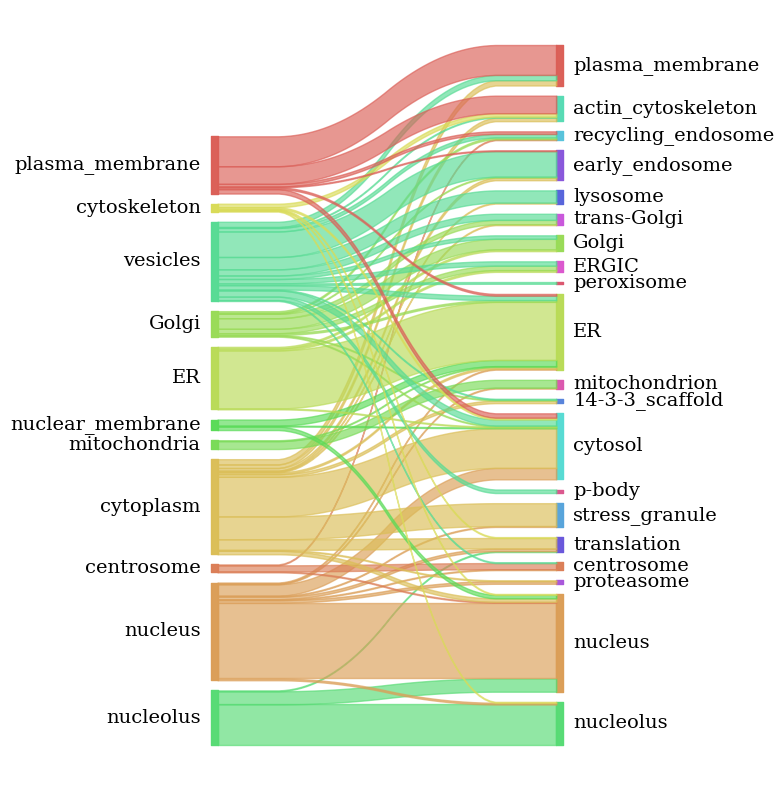

In [54]:
left_order= ['plasma_membrane', 'cytoskeleton', 'vesicles', 'Golgi', 
'ER', 'nuclear_membrane', 'mitochondria', 'cytoplasm', 'centrosome', 'nucleus', 'nucleolus']

right_order = ['plasma_membrane', 'actin_cytoskeleton', 'recycling_endosome', 'early_endosome', 
 'lysosome', 'trans-Golgi', 'Golgi', 'ERGIC', 'peroxisome',  'ER', 'mitochondrion', '14-3-3_scaffold', 
 'cytosol', 'p-body', 'stress_granule', 'translation', 'centrosome', 'proteasome', 'nucleus', 'nucleolus']

plt.figure(figsize=(5,10))
sankey(data_single["annotations_grade3_simpler"], data_single["graph_annotation"], leftLabels=left_order[::-1], rightLabels=right_order[::-1])
plt.savefig(output_folder / "Sankey_imaging.pdf")


### confusion matrix (panel G)

In [55]:
# enumerate all pairwise combinations of annotations between cytoself (left order) and OrgIP (right order)
combinations = list(itertools.product(left_order, right_order))

In [56]:
# compute IoU
def compute_count(list1, list2, list1_item, list2_item):
    """
    Compute the intersection over union for two lists of annotations
    list1_item: the item in list1 to compare
    list2_item: the item in list2 to compare
    """
    assert list1_item in list1, f"{list1_item} not in {list1}"
    assert list2_item in list2, f"{list2_item} not in {list2}"

    intersection = sum((l1 == list1_item and l2 == list2_item) for l1, l2 in zip(list1, list2))

    return intersection 

confusion_results = {}

for combo in combinations:
    cytoself_label = combo[0]
    OrgIP_label = combo[1]
    IoU = compute_count(data_single["annotations_grade3_simpler"].to_list(), 
                      data_single["graph_annotation"].to_list(), 
                      cytoself_label, OrgIP_label)
    confusion_results[combo] = IoU


In [57]:
# process the results for plotting

# create a DataFrame with indices as left_order (cytoself) and columns as right_order (OrgIP)
confusion_df = pd.DataFrame(index=left_order, columns=right_order)

# fill the DataFrame with the computed values
for (i, j), value in confusion_results.items():
    confusion_df.at[i, j] = value

# fill the diagonal with NaN (or 0) since we are not calculating values for same element pairs
confusion_df.fillna(1, inplace=True)  # Or df.fillna(np.nan, inplace=True) if you want NaNs

In [58]:
# # uncomment to plot the raw counts

# # plot the confusion matrix as heatmap
# import seaborn as sns
# g = sns.clustermap(confusion_df, 
#                    annot=True, 
#                    row_cluster=False, col_cluster=False,
#                      cmap="YlGnBu",
#                      vmax=100, vmin=0, 
#                      annot_kws={"size": 12},
#                      figsize=(12, 12,),
#                      cbar_kws={"label": "IoU (intersect/union)"}
# )

                     
# # rotate the x-axis tick labels by 45 degrees
# plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha="right")
# # adjust the title position
# g.ax_heatmap.set_title("Agreement of annotations", pad=130, fontsize=18)  # Adjust the pad for the title
# # adjust the color bar position
# g.cax.set_position([0.02, 0.65, 0.03, 0.17])  # [left, bottom, width, height]
# # add a title to the color bar
# g.cax.set_ylabel("number of proteins", rotation=90, labelpad=15)
# # adjust the tick labels size
# plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=12)  # X-axis labels
# plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=12)  # Y-axis labels
# # adjust the color bar label size
# g.cax.yaxis.label.set_size(12)
# # adjust the color bar tick labels size
# g.cax.tick_params(labelsize=11)
# # set x and y labels
# g.ax_heatmap.set_xlabel('Organelle IP', fontsize=14)
# g.ax_heatmap.set_ylabel('cytoself', fontsize=14)

# plt.show()

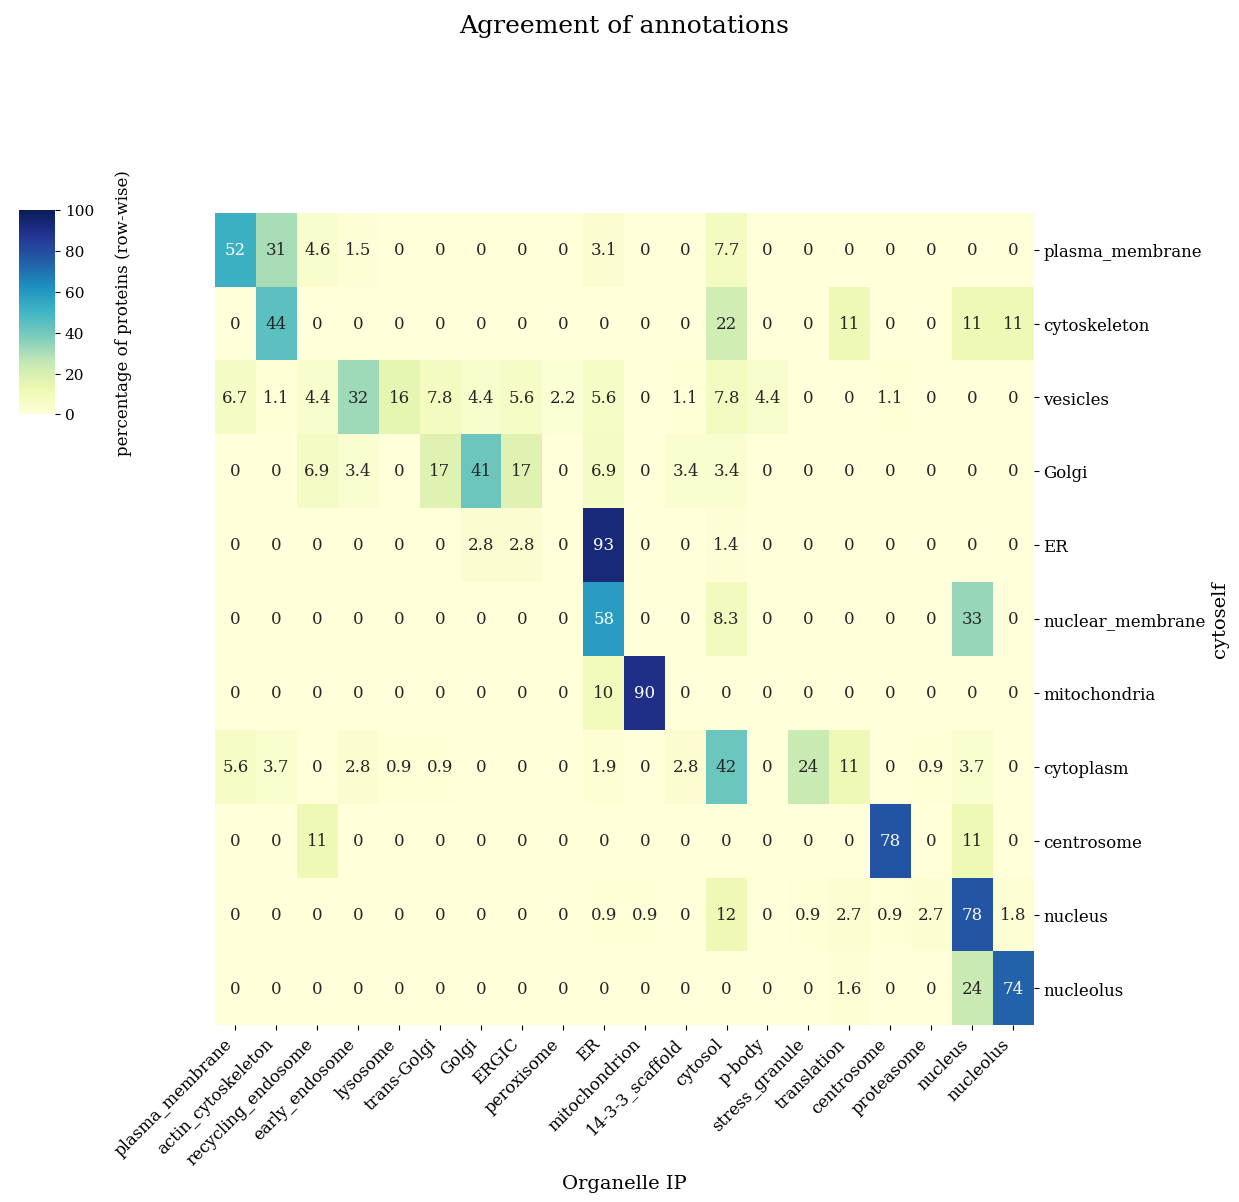

In [59]:
### report % so that row-wise adds to 100%
confusion_df_percent = confusion_df.div(confusion_df.sum(axis=1), axis=0) * 100
confusion_df_percent = confusion_df_percent.round(1) # round to 1 decimal place

# plot the confusion matrix as heatmap
import seaborn as sns
g = sns.clustermap(confusion_df_percent, 
                   annot=True, 
                   row_cluster=False, col_cluster=False,
                     cmap="YlGnBu",
                     vmax=100, vmin=0, 
                     annot_kws={"size": 12},
                     figsize=(12, 12,),
                     cbar_kws={"label": "IoU (intersect/union)"}
)

                     
# rotate the x-axis tick labels by 45 degrees
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha="right")
# adjust the title position
g.ax_heatmap.set_title("Agreement of annotations", pad=130, fontsize=18)  # Adjust the pad for the title
# adjust the color bar position
g.cax.set_position([0.02, 0.65, 0.03, 0.17])  # [left, bottom, width, height]
# add a title to the color bar
g.cax.set_ylabel("percentage of proteins (row-wise)", rotation=90, labelpad=15)
# adjust the tick labels size
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=12)  # X-axis labels
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=12)  # Y-axis labels
# adjust the color bar label size
g.cax.yaxis.label.set_size(12)
# adjust the color bar tick labels size
g.cax.tick_params(labelsize=11)
# set x and y labels
g.ax_heatmap.set_xlabel('Organelle IP', fontsize=14)
g.ax_heatmap.set_ylabel('cytoself', fontsize=14)

plt.show()